In [2]:

import seaborn as sns
import matplotlib.pyplot as plt



import os


# Limit the number of cores used by OpenMP
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["OPENBLAS_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"
import numpy as np
np.random.seed(49)
import pandas as pd

from helper_simulation import *
from helper_util import *
from comparison import ComparisonGong, ComparisonBodik

from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite.independence_tests import ParCorr
from tigramite import plotting as tp



from rpy2.robjects.conversion import localconverter


from scipy.stats import t as t_distribution
from rpy2.robjects.conversion import localconverter
import matplotlib.pyplot as plt
from datetime import datetime
current_date = datetime.now().strftime("%Y%m%d")    

%matplotlib inline



max_id=get_max("exp_result")
exp_str=""
log_path=f"exp_result/{str(max_id)}.{current_date}.simulationComparisonSingleTailVersion"

logger=get_logger(log_path)


INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /home/jianj0c/software/4.4/R-4.4.1
INFO:rpy2.situation:R library path: /home/jianj0c/software/4.4/R-4.4.1/lib:/usr/local/lib:/usr/lib/jvm/java-11-openjdk-amd64/lib/server:/home/jianj0c/software/4.4/R-4.4.1/lib:/usr/local/lib:/usr/lib/jvm/java-11-openjdk-amd64/lib/server:/usr/local/cuda/lib64:/usr/local/cuda/lib64
INFO:rpy2.situation:LD_LIBRARY_PATH: /home/jianj0c/software/4.4/R-4.4.1/lib:/usr/local/lib:/usr/lib/jvm/java-11-openjdk-amd64/lib/server:/home/jianj0c/software/4.4/R-4.4.1/lib:/usr/local/lib:/usr/lib/jvm/java-11-openjdk-amd64/lib/server:/usr/local/cuda/lib64:/usr/local/cuda/lib64
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.


exp_result/322.20250326.simulationComparisonSingleTailVersion/xx.log


In [8]:
num_nodes = 6  # number of nodes
n=5000 # number of samples
sparsity=0.3
quantile=1
pc_alpha=0.005

adjacency_matrix,edges_matrix = generate_dag(num_nodes,edge_probability=sparsity)

## This block generates a Directed Acyclic Graph (DAG) and simulates data based on it. Then, it performs causal inference on the generated data using two different methods (the method from this paper and Gong's method) and compares the error rates of the inferred results with the true graph. Finally, it plots the true graph and the inferred results from both methods.


### PART 1: non-timeseries version (cross-sectional data)

In [9]:
pathh=os.path.join(log_path,f"NodeSize:{num_nodes},EdgeSize:{(adjacency_matrix>0).sum()}.pdf")


IC_1=np.linalg.inv(np.eye(adjacency_matrix.shape[0])-adjacency_matrix)
N_data=simulation(n,num_nodes).T
X_data=otimes(IC_1,N_data,False)
data_df=pd.DataFrame(X_data.T)

the ground truth graph is:


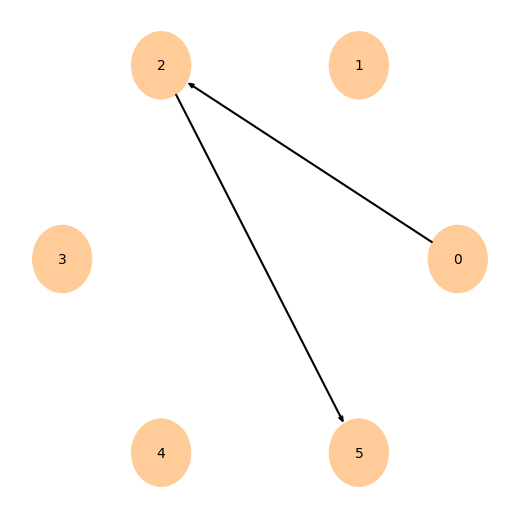

the results of this paper is: (with error rate: 0.0%)


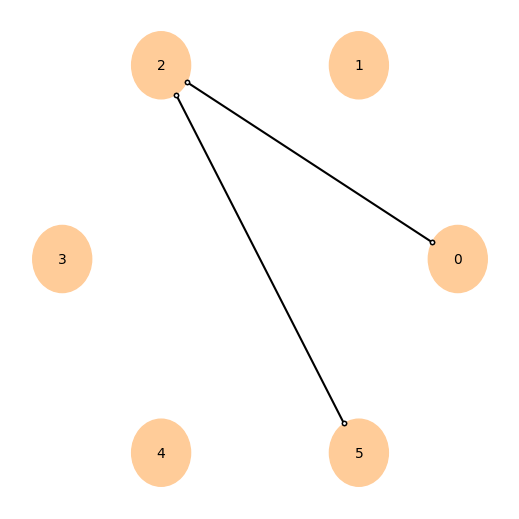

undetectable edges: {frozenset({0, 2}), frozenset({2, 5})}


In [10]:

from tigramite.independence_tests import CondIndTest

resultsThisPaper,details_result=method_this_paper(data_df,pc_alpha=pc_alpha,quantile=quantile,verbosity=0)

error_rate_this_paper,_=compare_graphs(resultsThisPaper,edges_matrix,True)

print("the ground truth graph is:")
        
        

draw_graph(edges_matrix,arrow_linewidth=3,arrowhead_size=5,label_fontsize=20,figsize=(5,5))
print("the results of this paper is: (with error rate: {:.1f}%)".format(error_rate_this_paper*100))
draw_graph(resultsThisPaper,arrow_linewidth=3,arrowhead_size=5,label_fontsize=20,figsize=(5,5))




arcs = set()
for i in range(edges_matrix.shape[0]):
    for j in range(edges_matrix.shape[1]):
        if edges_matrix[i,j,0]=="-->":
            arcs.add((i,j))
dag = cd.DAG(arcs=arcs)
cpdag = dag.cpdag()
print(f"undetectable edges: {cpdag.edges}")

In [21]:
compare_graphs_without_undirected(resultsThisPaper,edges_matrix)

(0.0, 0)

In [ ]:
import causaldag as cd
arcs = set()
for i in range(B.shape[0]):
    for j in range(B.shape[1]):
        if B[i,j] != 0:
            arcs.add((j+1,i+1))
dag = cd.DAG(arcs=arcs)
cpdag = dag.cpdag()

In [6]:
?compare_graphs

Signature:
compare_graphs(
    graph1,
    graph2,
    ignore_direction=False,
    ignore_comtemperous=False,
)
Docstring: <no docstring>
File:      ~/project/STP/code_publish/tailSCM/helper_simulation.py
Type:      function


In [7]:
from tigramite.independence_tests import ParCorr
?ParCorr

Init signature: ParCorr(**kwargs)
Docstring:     
Partial correlation test.

Partial correlation is estimated through linear ordinary least squares (OLS)
regression and a test for non-zero linear Pearson correlation on the
residuals.

Notes
-----
To test :math:`X \perp Y | Z`, first :math:`Z` is regressed out from
:math:`X` and :math:`Y` assuming the  model

.. math::  X & =  Z \beta_X + \epsilon_{X} \\
    Y & =  Z \beta_Y + \epsilon_{Y}

using OLS regression. Then the dependency of the residuals is tested with
the Pearson correlation test.

.. math::  \rho\left(r_X, r_Y\right)

For the ``significance='analytic'`` Student's-*t* distribution with
:math:`T-D_Z-2` degrees of freedom is implemented.

Parameters
----------
**kwargs :
    Arguments passed on to Parent class CondIndTest.
File:           ~/anaconda3/envs/py3-env/lib/python3.7/site-packages/tigramite/independence_tests/parcorr.py
Type:           ABCMeta
Subclasses:     


## have a lot of scatter plot to visualize the pairwise relationships


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# 生成转换后的数据，并去掉第一列和最后一行
transformed_df = tranform_frechet_df(data_df)

# 获取变量名
cols = transformed_df.columns
n = len(cols)  # 变量个数

# 创建 (n-1) x (n-1) 的子图，调整高宽比使图更扁
fig, axes = plt.subplots(n-1, n-1, figsize=(2.5 * (n-1), 1.5 * (n-1)), sharex='col', sharey='row')

# 遍历所有 (i, j) 组合，在 subplot 上绘制 scatterplot
for i in range(n-1):  # 行索引
    for j in range(n-1):  # 列索引
        ax = axes[i, j]

        if j >= i:  # 仅绘制上三角部分
            sns.scatterplot(x=transformed_df[cols[j+1]], y=transformed_df[cols[i]], ax=ax,
                            alpha=0.6, edgecolor='k', linewidth=0.5)

        # 仅在最底部一行显示 X 轴标签
        if i == n-2:
            ax.set_xlabel("$X_{}$".format(j+2), fontsize=20, labelpad=-1)  # 减小labelpad

        # 仅在最左侧一列显示 Y 轴标签
        if j == 0:
            ax.set_ylabel("$X_{}$".format(i+1), fontsize=20, labelpad=-1)  # 减小labelpad

        # 调整刻度
        ax.tick_params(axis='both', which='major', labelsize=18, length=8, width=1.5)

# 调整子图之间的间距
plt.tight_layout(pad=1.0)  # 减小pad值使图更紧凑

# 保存图像
plt.savefig(os.path.join(log_path, "pairwise_relationships_mechanical.png"), bbox_inches='tight', dpi=200)
plt.close()


# Time series version


We first do simulation and visualization

In [9]:
num_nodes = 6  # number of nodes
T=50000 # length of time series
sparsity_lag=0.3
sparsity_contemp=sparsity_lag
quantile=1 
burn_in=1000
pc_alpha=0.005
tau=1


## Random generated graph

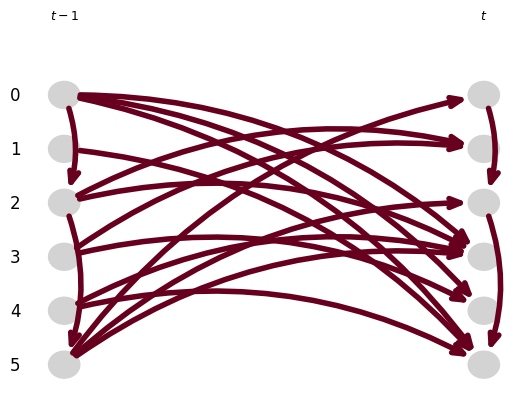

the spectral radius is 1.1963518180088655
the spectral radius is 0.8836392381265747


In [10]:

adjacency_matrix,true_graph=generate_dag_timeseries(num_nodes,sparsity_lag,sparsity_contemp,tau)
draw_graph_timeseries(true_graph,vmin_edges=0,vmax_edges=1,show_colorbar=False)
spectral_radius=compute_spectral_radius(adjacency_matrix)
print(f"the spectral radius is {spectral_radius}")
if spectral_radius>1:
    adjacency_matrix=adjacency_matrix/(spectral_radius*1.1)
    spectral_radius=compute_spectral_radius(adjacency_matrix)
    print(f"the spectral radius is {spectral_radius}")

In [11]:
data_df=simulation_timeseries(T,burn_in,adjacency_matrix)

## Realization

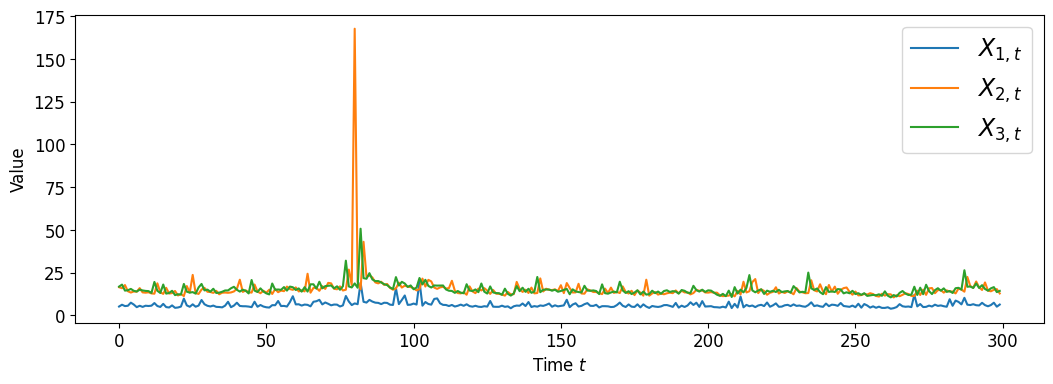

In [12]:
plt.figure(figsize=(12.5,4))
Start=1000
End=Start+300
plt.plot(data_df.iloc[Start:End].iloc[:,0].values, label='$X_{1,t}$')
plt.plot(data_df.iloc[Start:End].iloc[:,1].values, label='$X_{2,t}$')
plt.plot(data_df.iloc[Start:End].iloc[:,2].values, label='$X_{3,t}$')
plt.legend(fontsize=17)
plt.xlabel('Time $t$', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.savefig(os.path.join(log_path, "timeseries_simulation.png"), bbox_inches='tight', dpi=200)
plt.show()

In [13]:
os.path.join(log_path, "timeseries_simulation.png")

'exp_result/283.20250322.simulationComparisonSingleTailVersion/timeseries_simulation.png'

## the extremogram

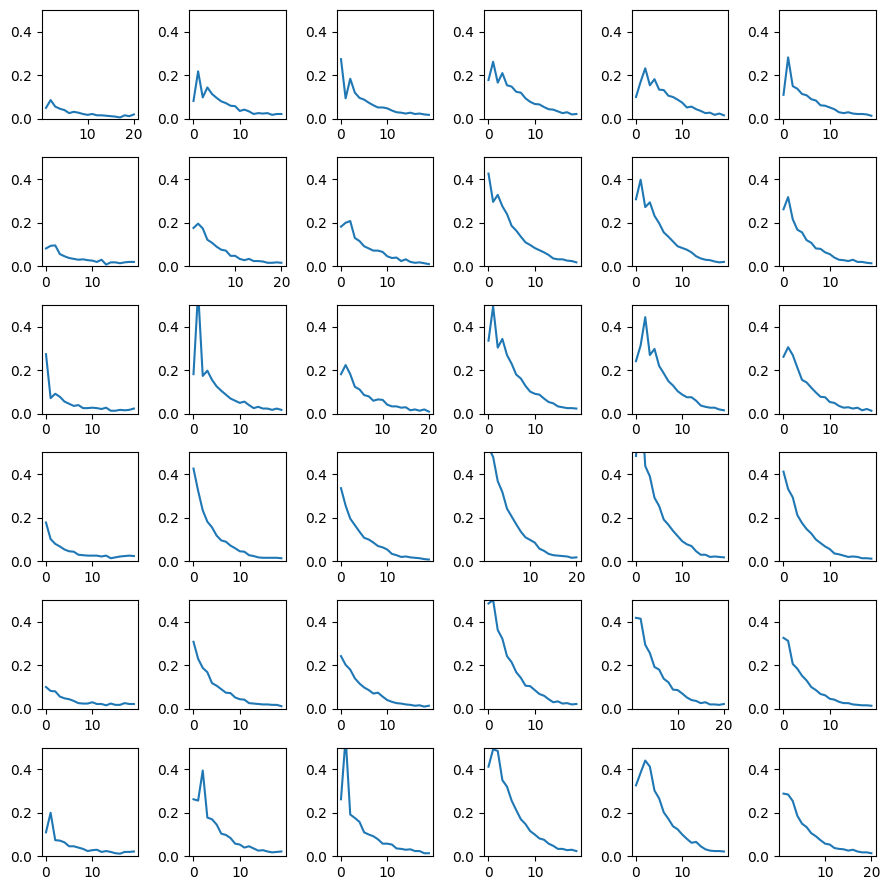

In [14]:

lagg=20
num_vars = data_df.shape[1]
fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=(9, 9))

for i in range(num_vars):
    for j in range(num_vars):
        if i==j:
            axes[i, j].plot(np.arange(1,lagg+1),extremeogram(data_df.values[:,[i,j]],maxlag=lagg+1)[1:])
        else:
            axes[i, j].plot(np.arange(lagg),extremeogram(data_df.values[:,[i,j]],maxlag=lagg))
        axes[i, j].set_ylim(0,0.5)



plt.tight_layout()
plt.show()

## then we do comparison with Bodik's method

In [24]:
num_nodes = 8  # number of nodes
T=5000 # length of time series
allow_contemp=True
sparsity_lag=0.1

sparsity_contemp=sparsity_lag if allow_contemp else 0
quantile=1 
burn_in=1000
pc_alpha=0.005
tau=1


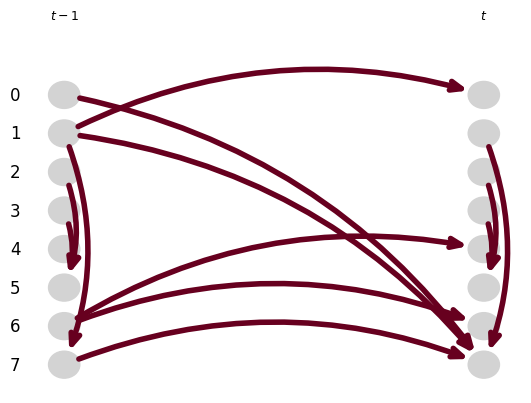

the spectral radius is 0.8839600994346669


<AxesSubplot:>

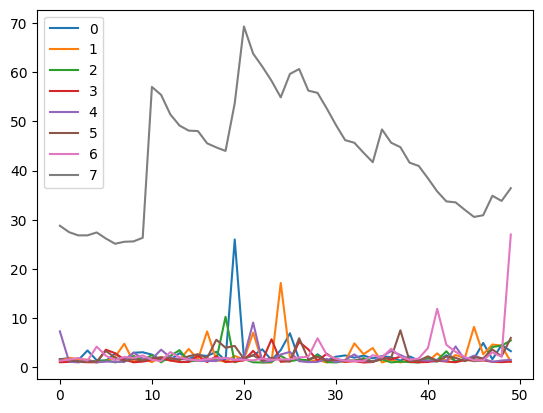

In [25]:

adjacency_matrix,true_graph=generate_dag_timeseries(num_nodes,sparsity_lag,sparsity_contemp,tau)
draw_graph_timeseries(true_graph,vmin_edges=0,vmax_edges=1,show_colorbar=False)

spectral_radius=compute_spectral_radius(adjacency_matrix)
print(f"the spectral radius is {spectral_radius}")
if spectral_radius>1:
    adjacency_matrix=adjacency_matrix/(spectral_radius*1.1)
    spectral_radius=compute_spectral_radius(adjacency_matrix)
    print(f"the spectral radius is {spectral_radius}")
data_df=simulation_timeseries(T,burn_in,adjacency_matrix)
data_df.iloc[:50].plot()


In [26]:
resultsThisPaper,_=method_this_paper(data_df,tau_max=1,tau_min=1 if allow_contemp else 0,quantile=quantile,pc_alpha=pc_alpha)
resultBodik=ComparisonBodik(data_df,1)


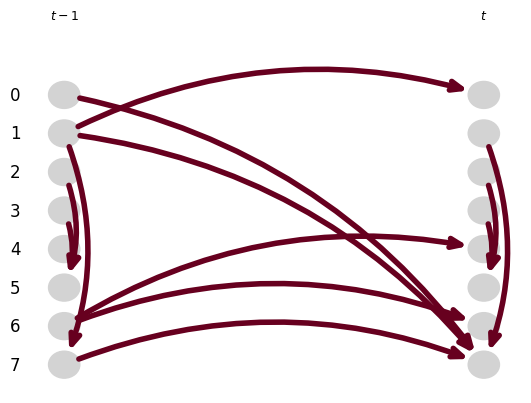

the results of this paper is: (with error rate: 17.6%)


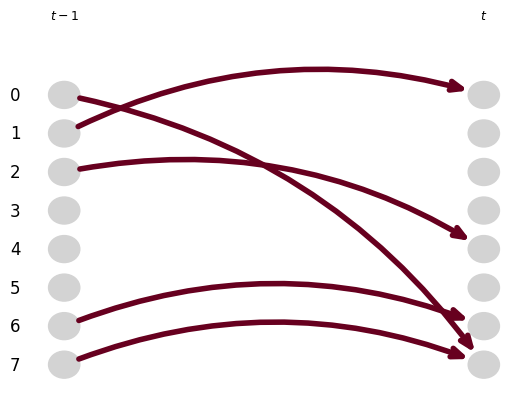

the results of bodik is: (with error rate: 20.0%)


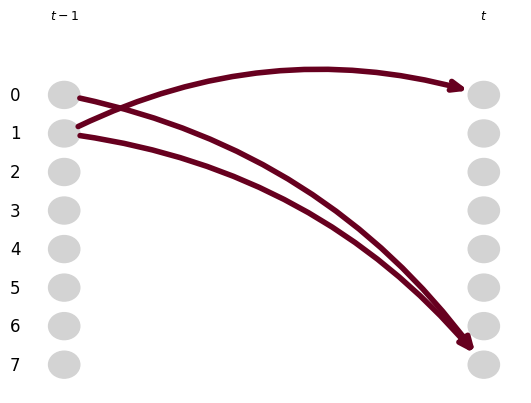

In [27]:
draw_graph_timeseries(true_graph,vmin_edges=0,vmax_edges=1,show_colorbar=False)
error_rate_this_paper,error_edges_this_paper=compare_graphs(resultsThisPaper,true_graph,ignore_comtemperous=True)
print(f"the results of this paper is: (with error rate: {error_rate_this_paper*100:.1f}%)")
draw_graph_timeseries(resultsThisPaper,vmin_edges=0,vmax_edges=1,show_colorbar=False)
error_rate_bodik,error_edges_bodik=compare_graphs(resultBodik,true_graph,ignore_comtemperous=True)
print(f"the results of bodik is: (with error rate: {error_rate_bodik*100:.1f}%)")
draw_graph_timeseries(resultBodik,vmin_edges=0,vmax_edges=1,show_colorbar=False)


## Result on Markov network

In [14]:
num_nodes=6
sparsity=0.7
pc_alpha=0.005
n=5000
precision_Matrix,edges_matrix=generate_markov_network(num_nodes,sparsity)

tpdm=np.linalg.inv(precision_Matrix)
weights=np.linalg.cholesky(tpdm)



In [23]:
precision_Matrix.round(2)

array([[ 2.02, -0.06, -0.63, -0.63, -0.35, -0.54],
       [-0.06,  2.02, -0.7 ,  0.  , -0.75,  0.  ],
       [-0.63, -0.7 ,  2.02, -0.34,  0.  ,  0.  ],
       [-0.63,  0.  , -0.34,  2.02,  0.  , -0.13],
       [-0.35, -0.75,  0.  ,  0.  ,  2.02, -0.42],
       [-0.54,  0.  ,  0.  , -0.13, -0.42,  2.02]])

In [24]:

N_data=simulation(n,num_nodes).T
X_data=otimes(weights.T,N_data,False)
data_df=pd.DataFrame(X_data.T)






In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# 生成转换后的数据，并去掉第一列和最后一行
transformed_df = tranform_frechet_df(data_df)

# 获取变量名
cols = transformed_df.columns
n = len(cols)  # 变量个数

# 创建 (n-1) x (n-1) 的子图，调整高宽比使图更扁
fig, axes = plt.subplots(n-1, n-1, figsize=(2.5 * (n-1), 1.5 * (n-1)), sharex='col', sharey='row')

# 遍历所有 (i, j) 组合，在 subplot 上绘制 scatterplot
for i in range(n-1):  # 行索引
    for j in range(n-1):  # 列索引
        ax = axes[i, j]

        if j >= i:  # 仅绘制上三角部分
            sns.scatterplot(x=transformed_df[cols[j+1]], y=transformed_df[cols[i]], ax=ax,
                            alpha=0.6, edgecolor='k', linewidth=0.5)

        # 仅在最底部一行显示 X 轴标签
        if i == n-2:
            ax.set_xlabel("$X_{}$".format(j+2), fontsize=20, labelpad=-1)  # 减小labelpad

        # 仅在最左侧一列显示 Y 轴标签
        if j == 0:
            ax.set_ylabel("$X_{}$".format(i+1), fontsize=20, labelpad=-1)  # 减小labelpad

        # 调整刻度
        ax.tick_params(axis='both', which='major', labelsize=18, length=8, width=1.5)

# 调整子图之间的间距
plt.tight_layout(pad=1.0)  # 减小pad值使图更紧凑

# 保存图像
plt.savefig(os.path.join(log_path, "pairwise_relationships_mechanical_markov.png"), bbox_inches='tight', dpi=200)
plt.close()


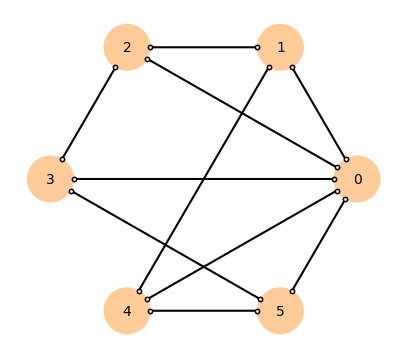

In [22]:
draw_graph(edges_matrix,arrow_linewidth=3,arrowhead_size=5,label_fontsize=20,figsize=(5,5))

the ground truth graph is:


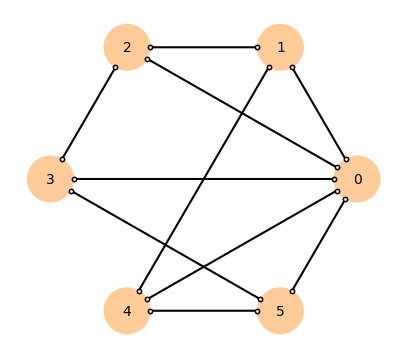

the results of this paper is: (with error rate: 42.9%)


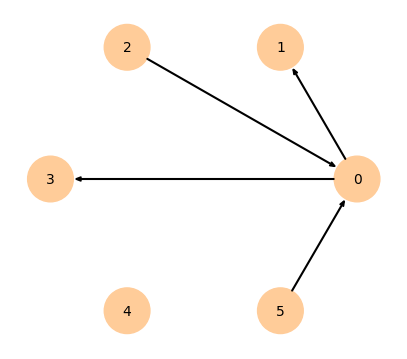

the results of Gong is: (with error rate: 53.8%)


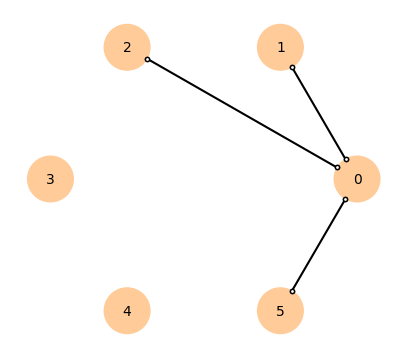

In [21]:
resultsThisPaper,_=method_this_paper(data_df,pc_alpha=pc_alpha,quantile=quantile)

error_rate_this_paper,_=compare_graphs(resultsThisPaper,edges_matrix)

print("the ground truth graph is:")
        
    
draw_graph(edges_matrix,arrow_linewidth=3,arrowhead_size=5,label_fontsize=20,figsize=(5,5))
print("the results of this paper is: (with error rate: {:.1f}%)".format(error_rate_this_paper*100))
draw_graph(resultsThisPaper,arrow_linewidth=3,arrowhead_size=5,label_fontsize=20,figsize=(5,5))

resultsGong=ComparisonGong(data_df,alpha = 0.04, beta = 1.26)
error_rate_gong,_=compare_graphs(resultsGong,edges_matrix)
print("the results of Gong is: (with error rate: {:.1f}%)".format(error_rate_gong*100))
draw_graph(resultsGong,arrow_linewidth=3,arrowhead_size=5,label_fontsize=20,figsize=(5,5))

For large scale comparsion with Gong; see [comparisonWithGong_v2.py](comparisonWithGong_v2.py) where we optimize the parameters for Gong's.

For large scale comparison with Bodik; see [comparisonWithBodik.py](comparisonWithBodik.py).